# **Define Problem Statement and perform Exploratory Data Analysis**

**Defination of Problem:**

**Context:**

*  Industry Challenge: The ride-hailing industry, represented here by Ola, faces a high turnover rate among drivers. This churn is problematic as it disrupts operations, impacts morale, and increases costs due to the need for continuous recruitment.

* Business Impact: High churn can impede the growth and efficiency of the company. Retaining drivers is less costly and more beneficial than constantly hiring and training new ones.

**Objective:**

* Predictive Modeling: Your task is to develop a predictive model that can determine whether a driver is likely to leave the company. This prediction will be based on various attributes related to the drivers.


**Additional Views**

By predicting driver attrition, Ola can:

* Implement Retention Strategies: Identify at-risk drivers early and offer incentives, support, or interventions to retain them.

* Optimize Recruitment: Focus recruitment efforts on profiles with lower predicted churn.

* Improve Driver Experience: Address systemic issues causing dissatisfaction, thus reducing overall churn rates and improving driver morale.


In [ ]:
pip install category_encoders

In [173]:
# Importing necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from  xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

import warnings
warnings.filterwarnings("ignore")

In [215]:
link = "/content/drive/MyDrive/ola_driver_scaler.csv"
df = pd.read_csv(link)
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


**Shape of Data**

In [216]:
df.shape

(19104, 14)

**data types of all the attributes**

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


**conversion of categorical attributes to 'category'**

MMM-YY, DateofJoining, LastWorkingDate columns needs to be converted into datatime format and dropping Unnamed: 0 column since it is reepresenting index only

In [218]:
df["MMM-YY"] = pd.to_datetime(df["MMM-YY"])
df["Dateofjoining"] = pd.to_datetime(df["Dateofjoining"])
df["LastWorkingDate"] = pd.to_datetime(df["LastWorkingDate"])
df.drop(columns = ["Unnamed: 0"], inplace = True)

In [219]:
for i in df.columns[1:-1]:
  if np.issubdtype(df[i].dtype, np.object_):
    print(i, df[i].unique())

City ['C23' 'C7' 'C13' 'C9' 'C11' 'C2' 'C19' 'C26' 'C20' 'C17' 'C29' 'C10'
 'C24' 'C14' 'C6' 'C28' 'C5' 'C18' 'C27' 'C15' 'C8' 'C25' 'C21' 'C1' 'C4'
 'C3' 'C16' 'C22' 'C12']


In [220]:
for i in df.columns[1:-1]:
  if np.issubdtype(df[i].dtype, np.number):
    print(i, df[i].unique())
    print("------------------------")

Driver_ID [   1    2    4 ... 2786 2787 2788]
------------------------
Age [28. 31. 43. 29. 34. 35. 30. 39. 42. 27. 26. nan 33. 40. 41. 32. 22. 44.
 36. 21. 49. 37. 38. 46. 47. 48. 25. 24. 45. 51. 52. 23. 50. 53. 54. 55.
 58.]
------------------------
Gender [ 0.  1. nan]
------------------------
Education_Level [2 0 1]
------------------------
Income [57387 67016 65603 ... 35370 69498 70254]
------------------------
Joining Designation [1 2 3 4 5]
------------------------
Grade [1 2 3 4 5]
------------------------
Total Business Value [2381060 -665480       0 ...  497690  740280  448370]
------------------------


**missing value detection**

In [221]:
df.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

There are missing values in dataset.

**Handling missing values**

In [222]:
# Using KNN imputataion for filling missing values in Age and Gender column.
columns_to_impute = ["Age", "Gender"]
df_to_impute = df[columns_to_impute]
imputer = KNNImputer(n_neighbors=2, weights = 'uniform')
df_imputed = pd.DataFrame(imputer.fit_transform(df_to_impute), columns=columns_to_impute)
df[columns_to_impute] = df_imputed[columns_to_impute]
df.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                         0
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

**Aggregate data in order to remove multiple occurrences of same driver data**

In [238]:
# Aggregate data in order to remove multiple occurrences of same driver data
data = df.groupby(by = ["Driver_ID"]).agg({"MMM-YY" : ["first", "last"], "Age" : "last", "Gender" : "last", "City" : "last",
                                    "Education_Level" : "last", "Income" : ["first","last"], "Dateofjoining" : "first", "LastWorkingDate" : "last",
                                    "Joining Designation" : "first", "Grade" : "last", "Total Business Value": "sum", "Quarterly Rating" : ["first", "last"]}).reset_index()
data.columns = data.columns.map(lambda x: x[0])
data.columns = ['Driver_ID', 'MMM-YY_first','MMM-YY_last', 'Age', 'Gender', 'City',
       'Education_Level', 'Income_first', 'Income_last', 'Dateofjoining',
       'LastWorkingDate', 'Joining Designation', 'Grade',
       'Total Business Value', 'QuarterlyRating_first', 'QuarterlyRating_last']

**Feature Engineering**

In [239]:
# Considering todat is 9999-12-31 filling null values to calculate tenure of drivers by the same.
data["LastWorkingDate"].fillna("2099-12-31", inplace = True)

# Creating Tenure column to calculate the Tenure of driver working
data["Tenure"] = data["MMM-YY_last"] - data["MMM-YY_first"]
data["Tenure"] = data["Tenure"].astype(str).apply(lambda x: int(x.split()[0]))

# Feature 1: Target variable creation:the driver whose last working day is present will have the value 1.
data["Target"] = ["Present" if i == pd.to_datetime('2099-12-31', format='%Y-%m-%d') else "Churned" for i in data['LastWorkingDate']]

# Feature 2: the quarterly rating has increased for that driver or not - for those whose quarterly rating has increased assigning the value 1
data["QuarterlyRatingIncreased"] = (data["QuarterlyRating_last"] > data["QuarterlyRating_first"]).astype(int)

# Feature 3: the income has increased for that driver or not - for those whose income has increased assigning the value 1
data["IncomeIncreased"] = (data["Income_last"] > data["Income_first"]).astype(int)


In [240]:
data.columns

Index(['Driver_ID', 'MMM-YY_first', 'MMM-YY_last', 'Age', 'Gender', 'City',
       'Education_Level', 'Income_first', 'Income_last', 'Dateofjoining',
       'LastWorkingDate', 'Joining Designation', 'Grade',
       'Total Business Value', 'QuarterlyRating_first', 'QuarterlyRating_last',
       'Tenure', 'Target', 'QuarterlyRatingIncreased', 'IncomeIncreased'],
      dtype='object')

**Statistical summary of the derived dataset**

In [198]:
data.describe()

,Driver_ID,MMM-YY_first,MMM-YY_last,Age,Gender,Education_Level,Income_first,Income_last,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,QuarterlyRating_first,QuarterlyRating_last,Tenure,QuarterlyRatingIncreased,IncomeIncreased
count,2381.000000,2381,2381,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381,2381,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,1397.559009,2019-08-30 15:12:37.496849920,2020-03-31 15:04:09.475010560,33.670727,0.411592,1.00756,59209.060899,59334.157077,2019-02-08 07:14:50.550189056,2045-09-07 00:06:39.160016384,1.820244,2.096598,4.586742e+06,1.486350,1.427971,213.994120,0.150357,0.018060
min,1.000000,2019-01-01 00:00:00,2019-01-01 00:00:00,21.000000,0.000000,0.00000,10747.000000,10747.000000,2013-04-01 00:00:00,2018-12-31 00:00:00,1.000000,1.000000,-1.385530e+06,1.000000,1.000000,0.000000,0.000000,0.000000
25%,695.000000,2019-01-01 00:00:00,2019-09-01 00:00:00,29.000000,0.000000,0.00000,39104.000000,39104.000000,2018-06-29 00:00:00,2019-09-22 00:00:00,1.000000,1.000000,0.000000e+00,1.000000,1.000000,61.000000,0.000000,0.000000
50%,1400.000000,2019-07-01 00:00:00,2020-06-01 00:00:00,33.000000,0.000000,1.00000,55276.000000,55315.000000,2019-07-21 00:00:00,2020-06-27 00:00:00,2.000000,2.000000,8.176800e+05,1.000000,1.000000,123.000000,0.000000,0.000000
75%,2100.000000,2020-05-01 00:00:00,2020-12-01 00:00:00,37.000000,1.000000,2.00000,75765.000000,75986.000000,2020-05-02 00:00:00,2099-12-31 00:00:00,2.000000,3.000000,4.173650e+06,2.000000,2.000000,275.000000,0.000000,0.000000
max,2788.000000,2020-12-01 00:00:00,2020-12-01 00:00:00,58.000000,1.000000,2.00000,188418.000000,188418.000000,2020-12-28 00:00:00,2099-12-31 00:00:00,5.000000,5.000000,9.533106e+07,4.000000,4.000000,700.000000,1.000000,1.000000
std,806.161628,NaN,NaN,5.973676,0.492225,0.81629,28275.899087,28383.666384,NaN,NaN,0.841433,0.941522,9.127115e+06,0.834348,0.809839,206.574767,0.357496,0.133195


In [199]:
data.describe(include= object)

,City,Target
count,2381,2381
unique,29,2
top,C20,Churned
freq,152,1616


In [243]:
data["Target"].value_counts(normalize = True)*100

Target
Churned    67.870643
Present    32.129357
Name: proportion, dtype: float64

It looks like 68% of driver are churened from company only 32% left, Target data is imbalanced

**Univariate Analysis**

In [246]:
distribution_continuous = ["Age", "Income_last", "Total Business Value", "Tenure"]
distribution_categorical = ["Gender", "Education_Level", "Joining Designation", "Grade", "QuarterlyRating_first", "QuarterlyRating_last", "Target", "QuarterlyRatingIncreased", "IncomeIncreased"]
distribution_date = ["Dateofjoining","LastWorkingDate"]

Boxplot for Continuous features

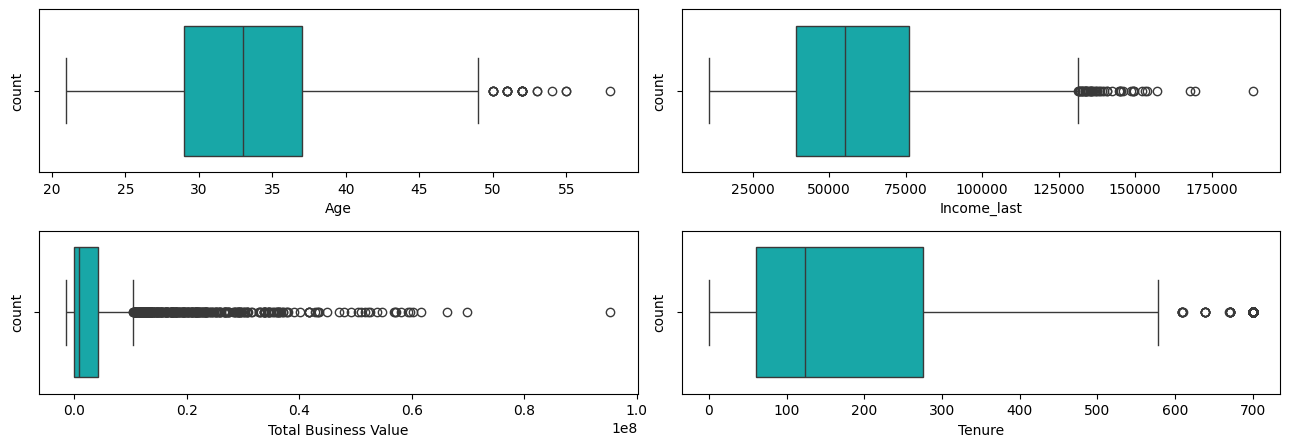

In [247]:
fig = plt.figure(figsize= (13, 13))
for i in range(0, len(distribution_continuous)):
  ax= plt.subplot(6, 2, i+1)
  sns.boxplot(x = data[distribution_continuous[i]], color = "c")
  plt.tight_layout()
  plt.ylabel("count")

There are outliers in the data.

Histplot for Continuous features

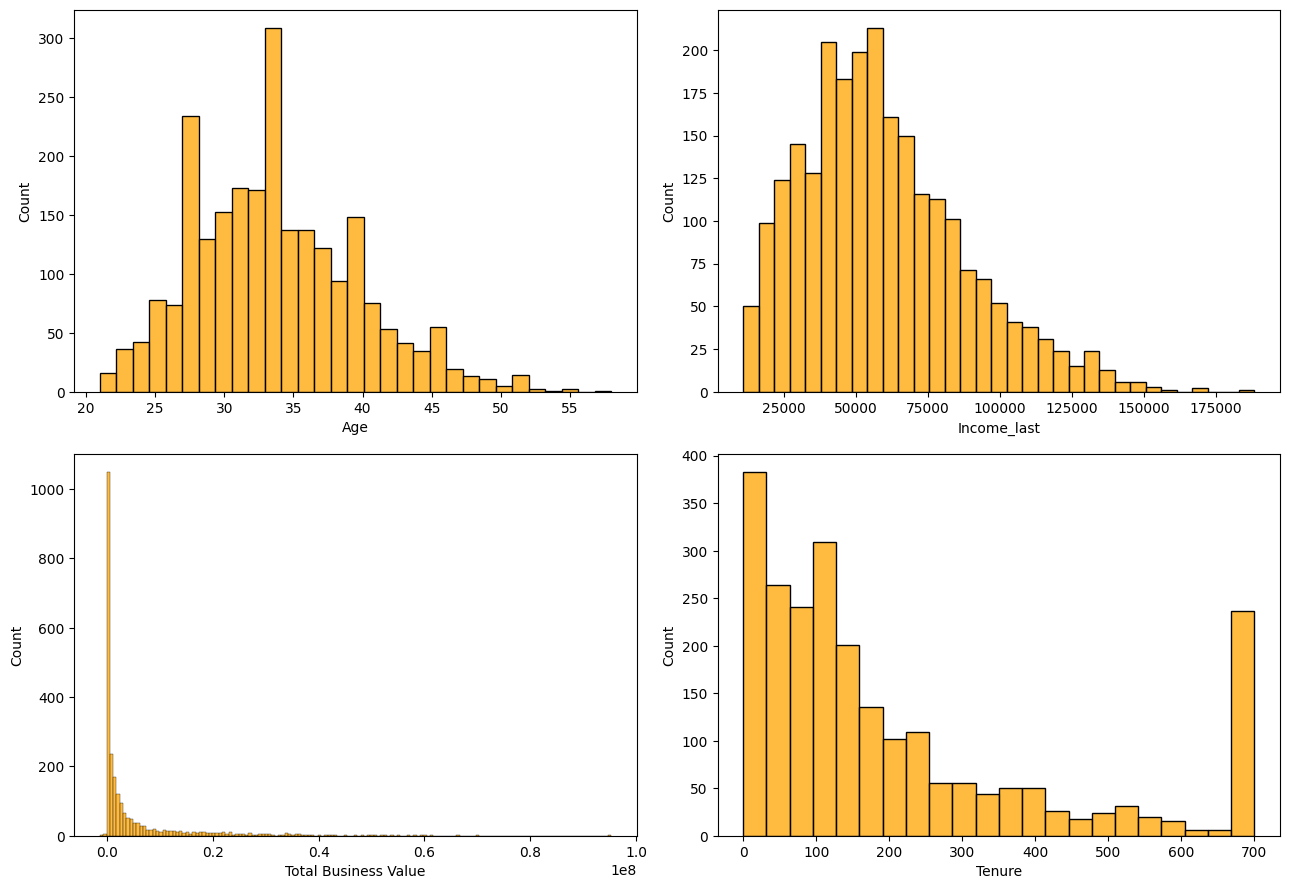

In [202]:
fig = plt.figure(figsize= (13, 13))
for i in range(0, len(distribution_continuous)):
  ax= plt.subplot(3, 2, i+1)
  sns.histplot(x = data[distribution_continuous[i]], color = "orange")
  plt.tight_layout()
  plt.ylabel("Count")

Income,Total_business value, Tenure are right skewed Age is less skewed to the right.

KDE plot for Date features

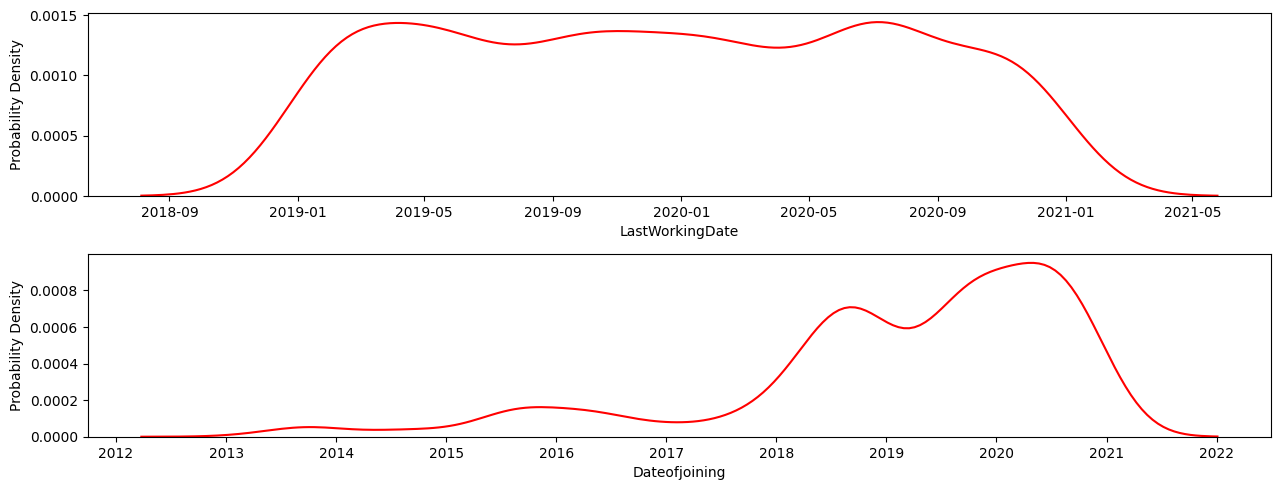

In [248]:
# plotting KDE of Lastworking days for those only who has left company
fig = plt.figure(figsize= (13, 5))

ax= plt.subplot(2, 1, 1)
sns.kdeplot(x = data.loc[data["LastWorkingDate"].dt.year < 2099, 'LastWorkingDate'], color = "Red")
plt.tight_layout()
plt.ylabel("Probability Density")


ax= plt.subplot(2, 1, 2)
sns.kdeplot(x = data["Dateofjoining"], color = "Red")
plt.tight_layout()
plt.ylabel("Probability Density")

plt.show()



Churn of drivers are most between year 2019 to 2020.
Most Drivers also joined after 2018.

Countplot for categorical features

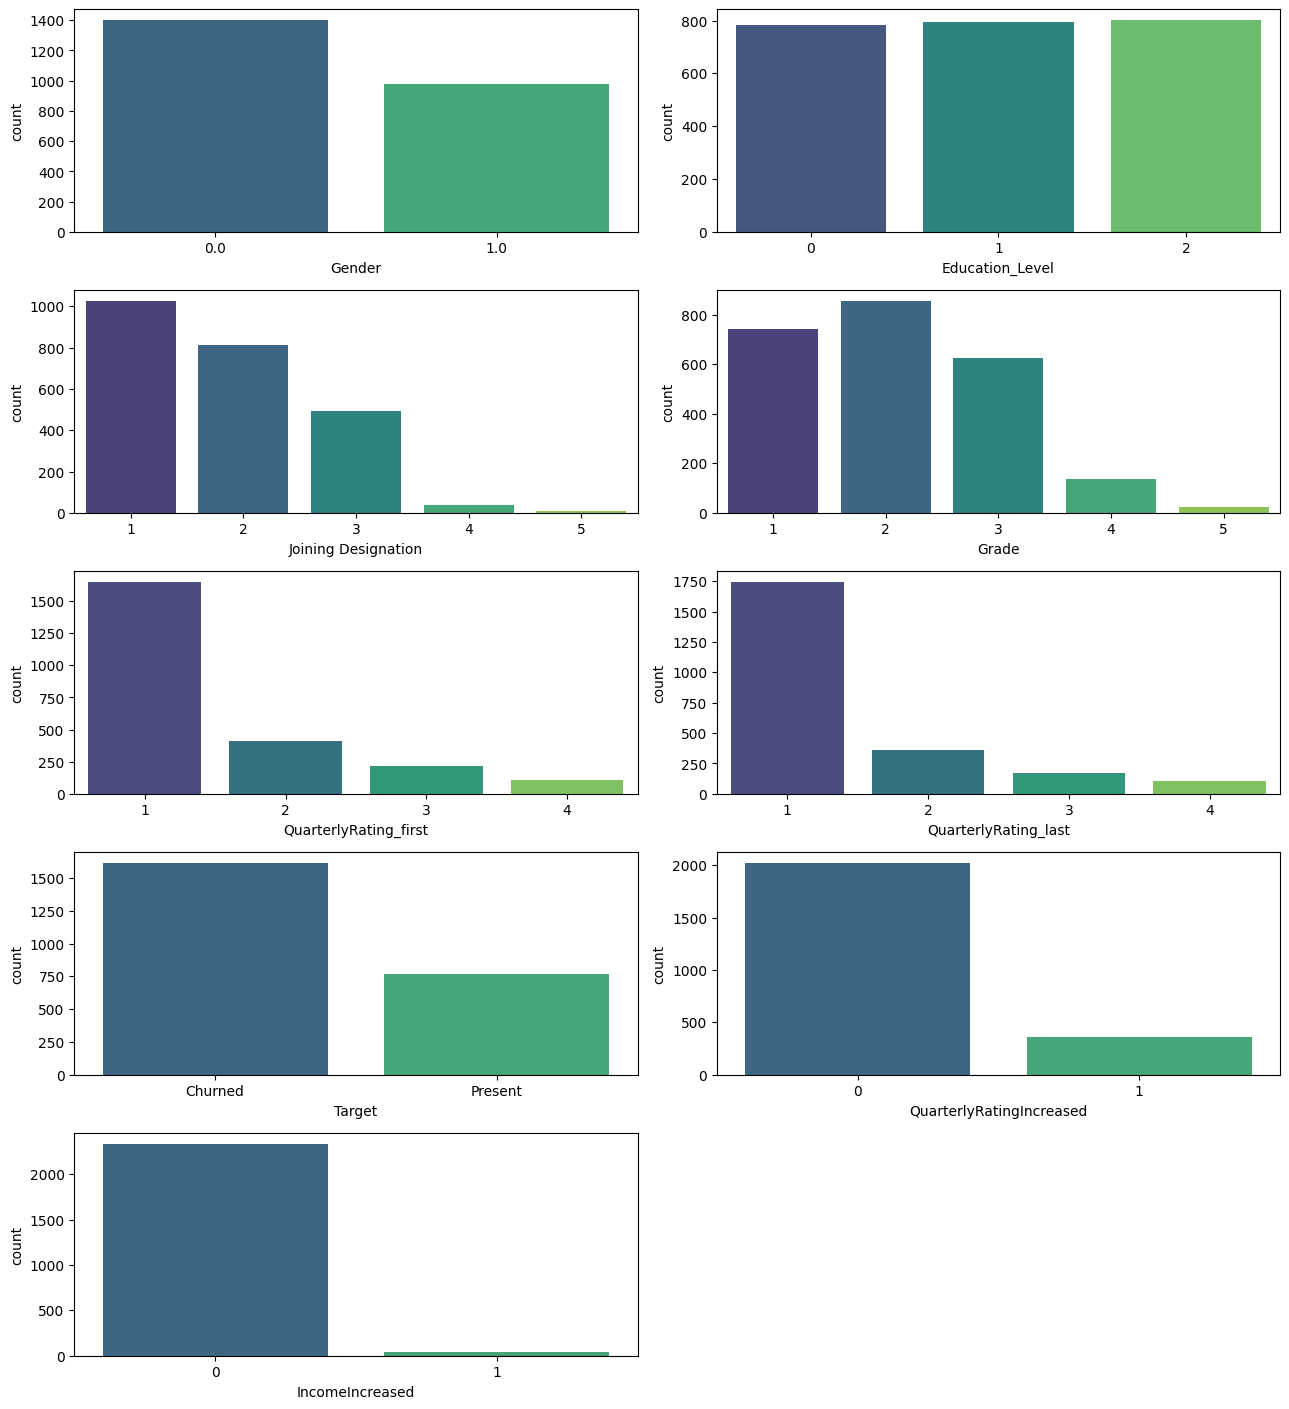

In [249]:
fig = plt.figure(figsize= (13, 25))
for i in range(0, len(distribution_categorical)):
  ax= plt.subplot(9, 2, i+1)
  sns.countplot(x = data[distribution_categorical[i]], palette= "viridis")
  plt.tight_layout()
  plt.ylabel("count")

By looking at target column data is imbalanced.

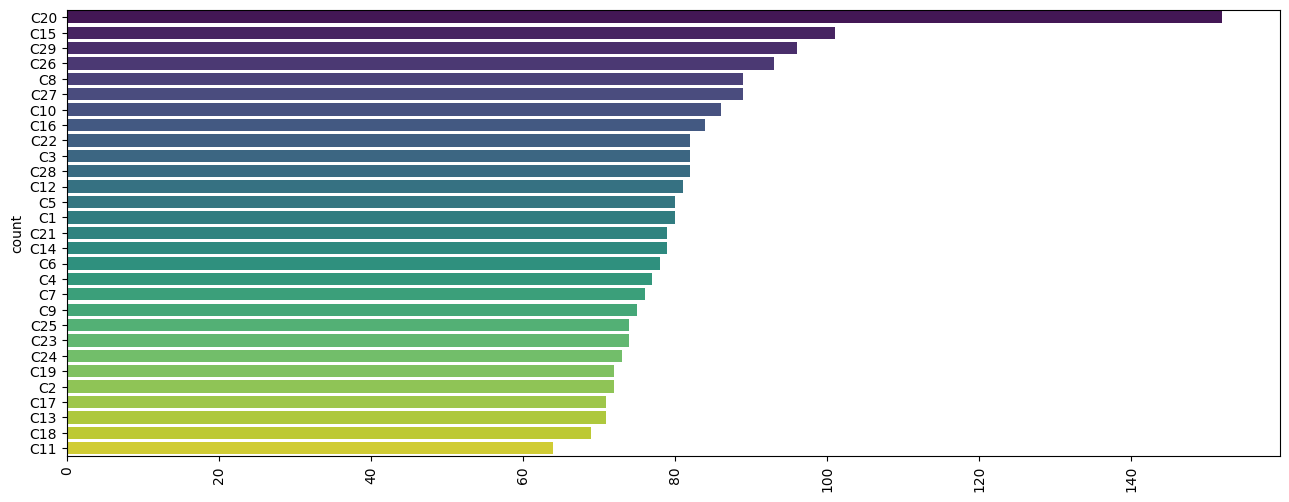

In [23]:
fig = plt.figure(figsize= (13, 5))
sns.barplot(y = data["City"].value_counts().index, x = data["City"].value_counts().values, palette= "viridis")
plt.tight_layout()
plt.xticks(rotation = 90)
plt.ylabel("count")
plt.show()

**Bivariate Analysis**

Correlation between numerical features

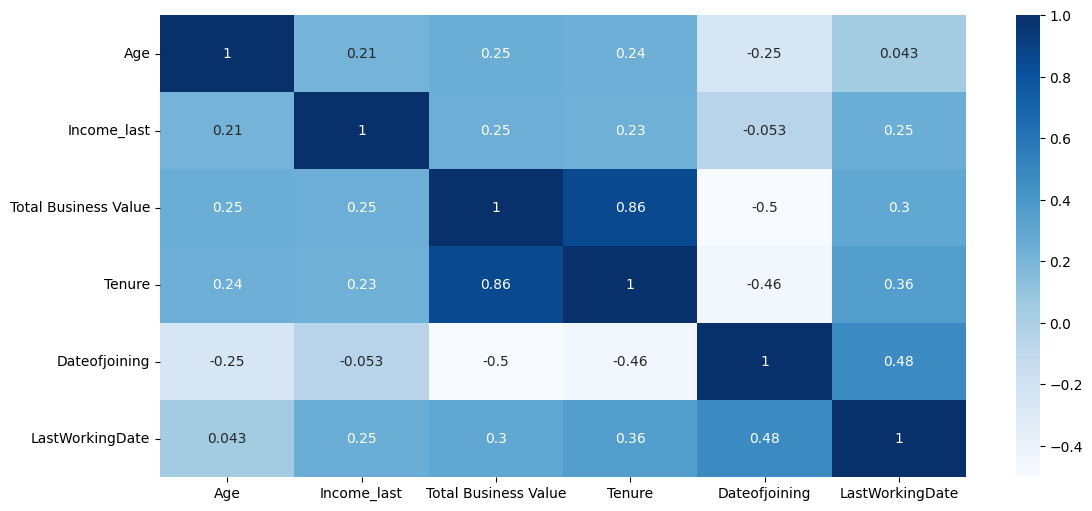

In [24]:
plt.figure(figsize= (13, 6))
sns.heatmap(data[distribution_continuous + distribution_date].corr(method = "spearman"), annot = True, cmap= "Blues")
plt.show()

Contengency Table of categorical feature w.r.t target

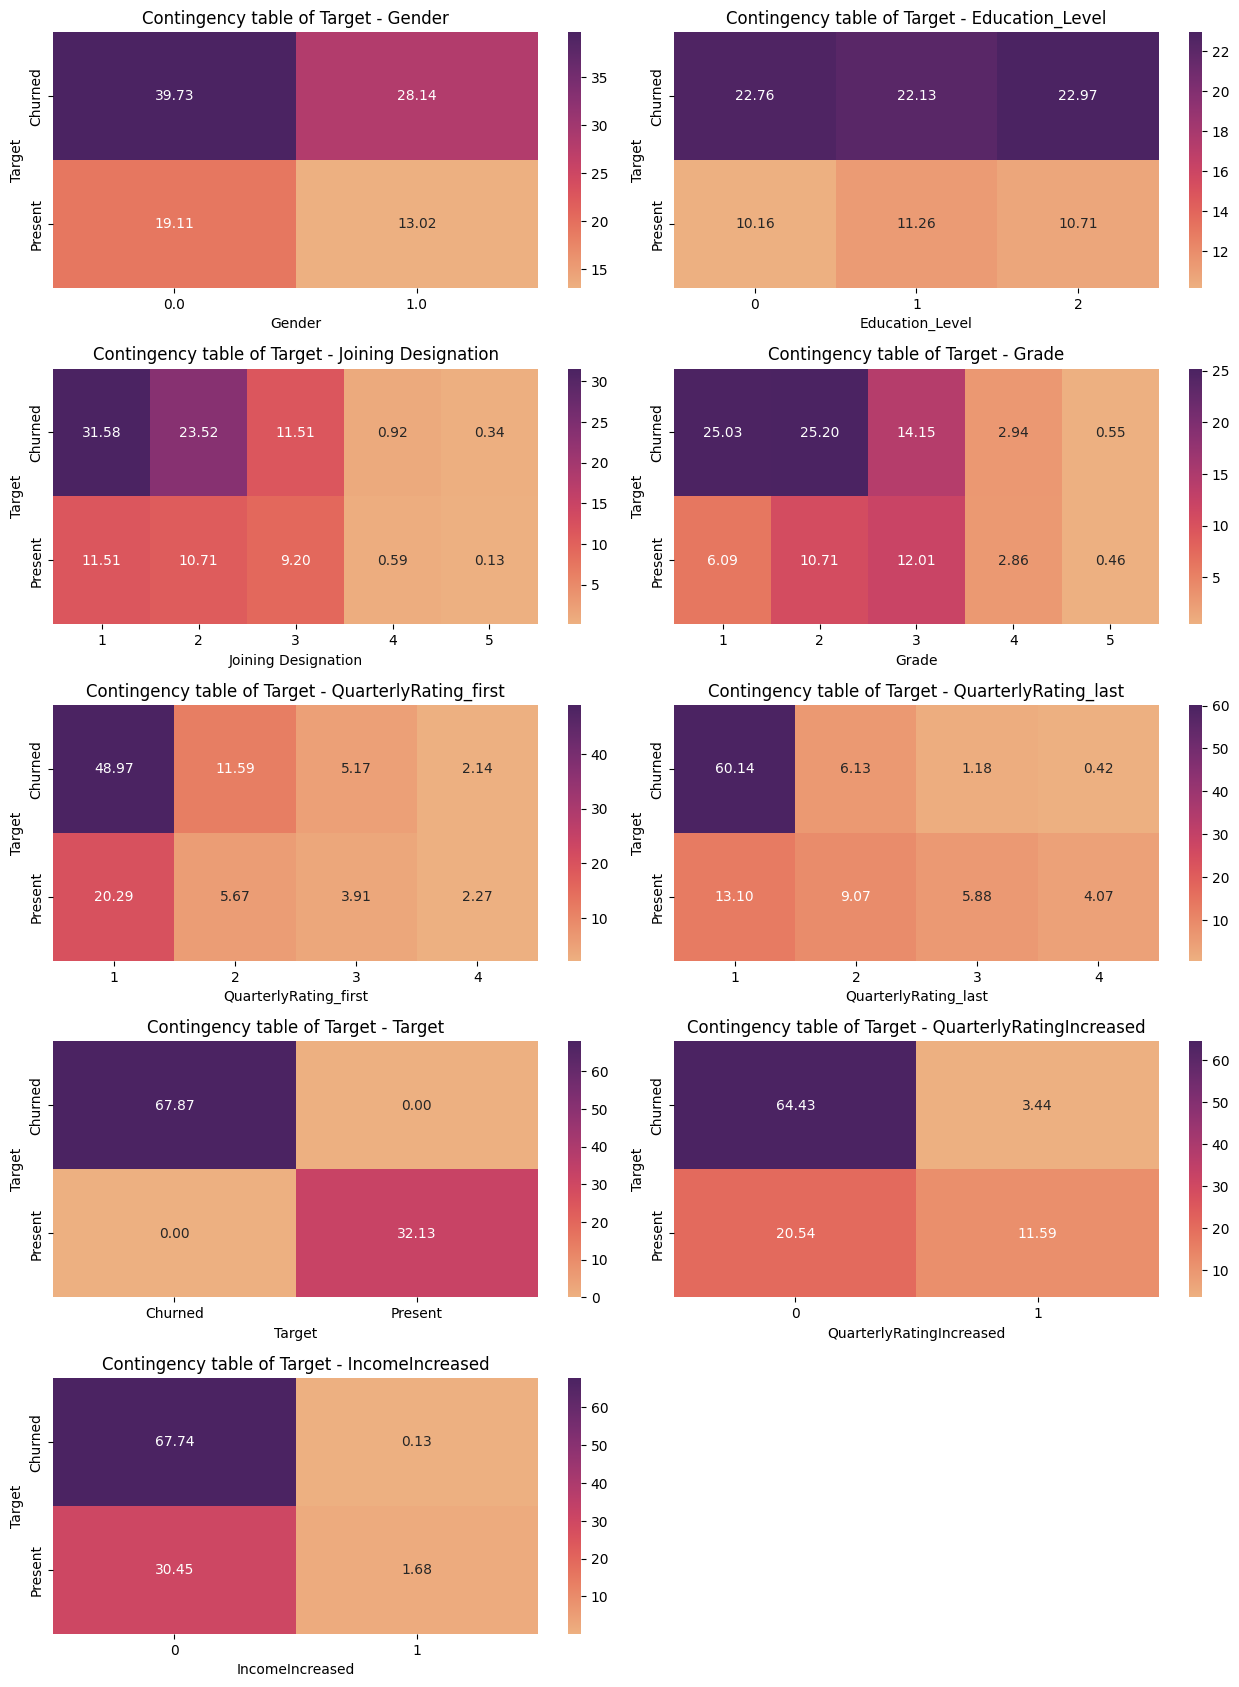

In [250]:
fig = plt.figure(figsize= (13, 30))

for i in range(0, len(distribution_categorical)):
  ax= plt.subplot(9, 2, i+1)
  plt.title(f"Contingency table of Target - {distribution_categorical[i]}")
  sns.heatmap(pd.crosstab(data["Target"], data[distribution_categorical[i]], normalize = True)*100, annot = True, cmap= "flare", fmt='.2f')
  plt.tight_layout()
  plt.ylabel("Target")

**Insights:-**

1. Gender-Based Churn:

* 39.73% of males have left the job, while 28.14% of females have left. This indicates that the male churn rate is higher than the female churn rate.

2. Education Level and Churn:

* The churn rate is almost the same across all education levels. However, the churn rate is slightly higher for those with Education Level 2.

3. Designation and Churn:

* Drivers who joined at Designation 1 have the highest churn rate, followed by those who joined at Designation 2.

4. Grade and Churn:

* 50% of drivers whose grade was 1 or 2 have left the job.

5. Quarterly Rating and Churn:

* Drivers who had a last quarterly rating of 1 have a churn rate of 60%. This implies that drivers with a rating of 1 at the time of leaving have a higher churn rate.

6. Overall Churn Rate (Target variable):

* 68% of drivers have left the job, while 32% are currently still working. Target is imbalanced.

7. Impact of Quarterly Rating Change on Churn:

* Among drivers whose quarterly rating did not increase, 64.43% left the job. In contrast, only 3.44% of those whose quarterly rating increased still left the job. This indicates that changes in quarterly rating significantly affect the churn rate.

8. Impact of Income Increase on Churn:

* For drivers whose income did not increase, 67.74% left the job. This is the most significant factor affecting churn rate.

**Bivariate Analysis of Catgorical and numerical features w.r.t. Target**

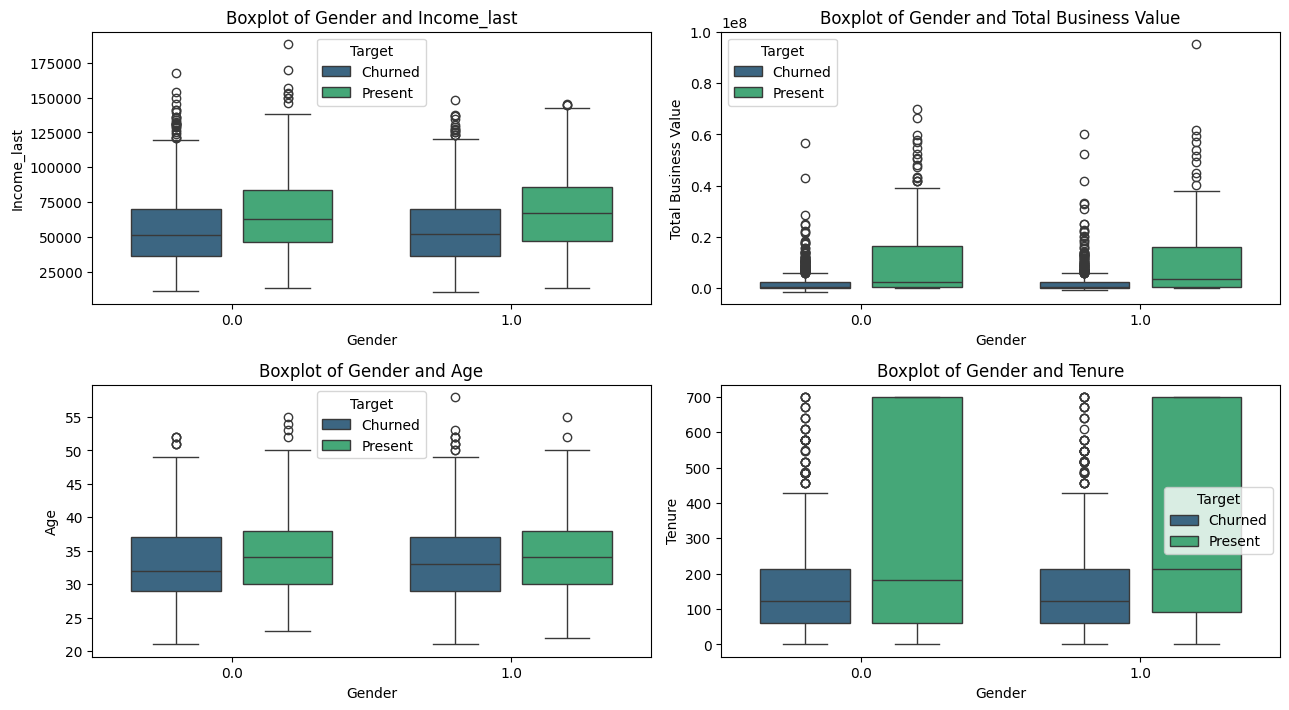

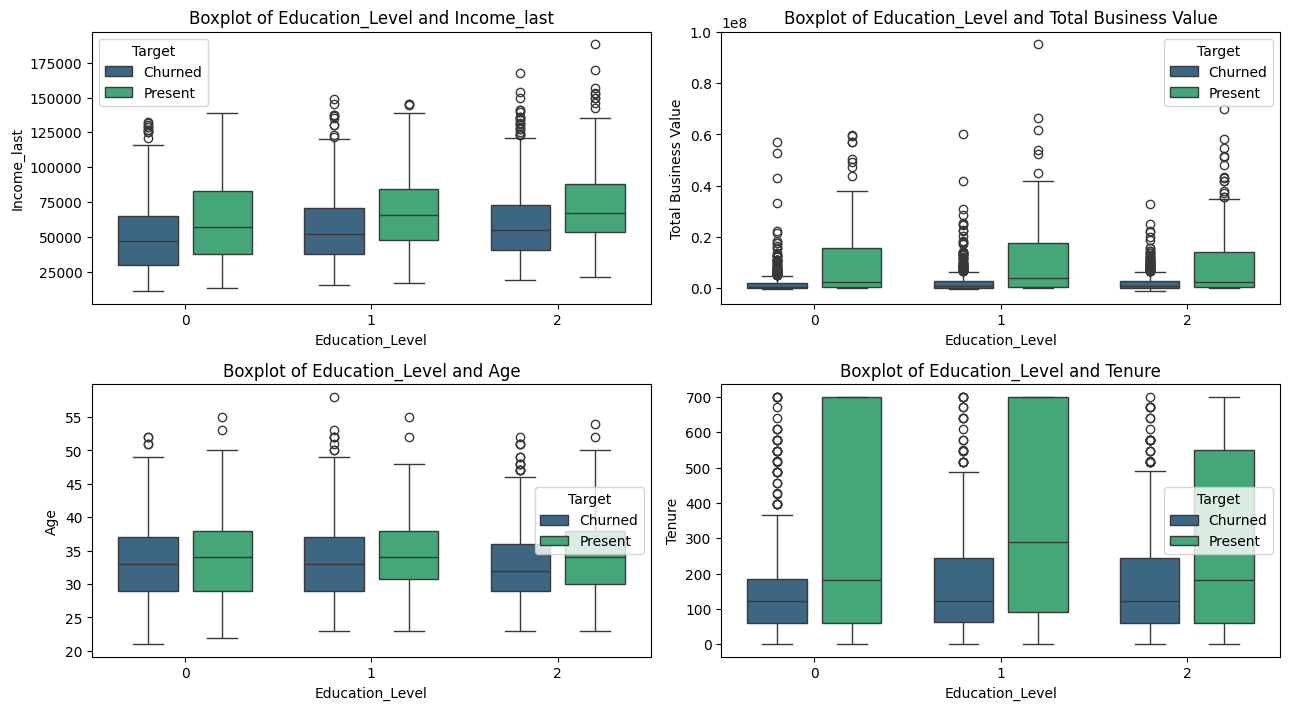

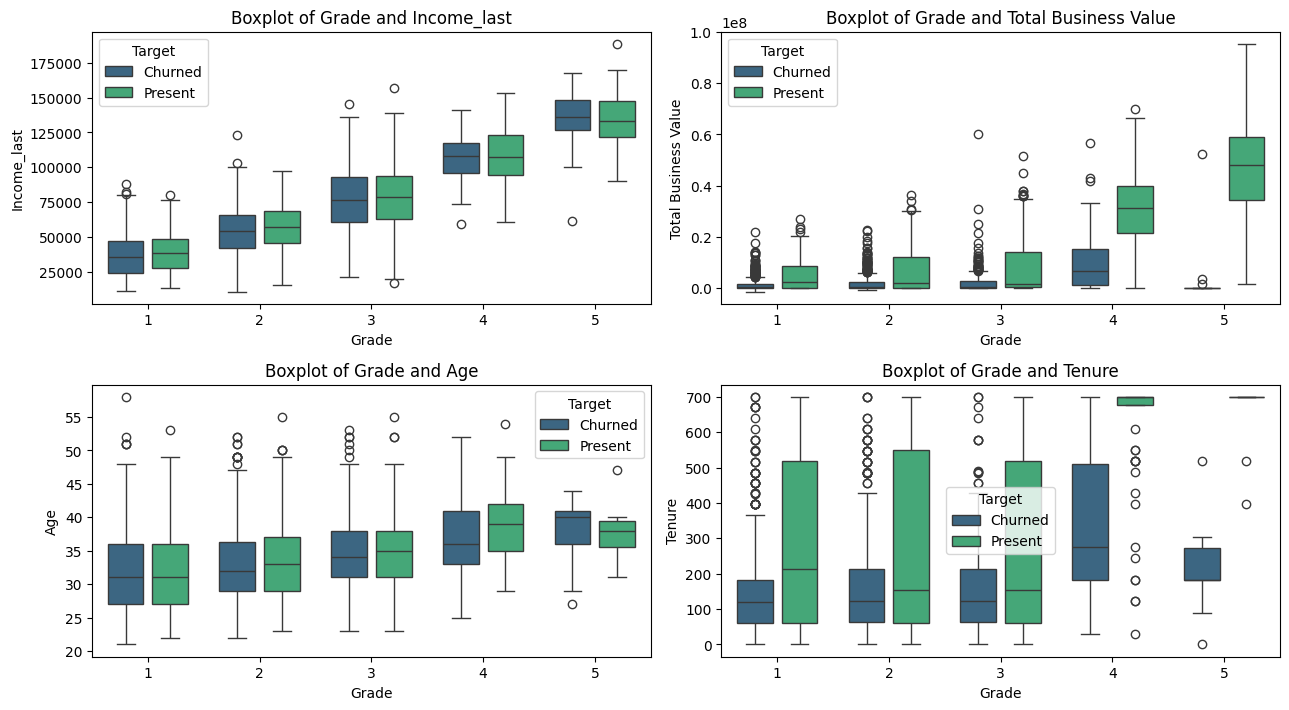

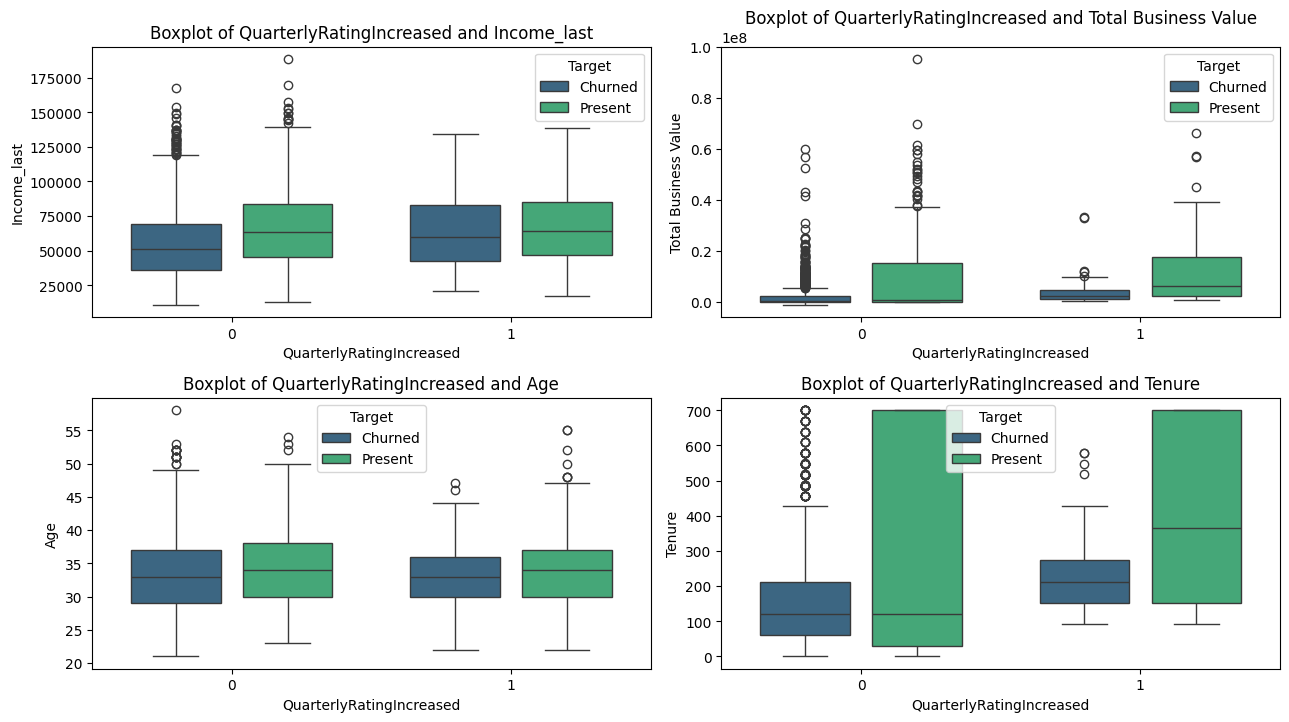

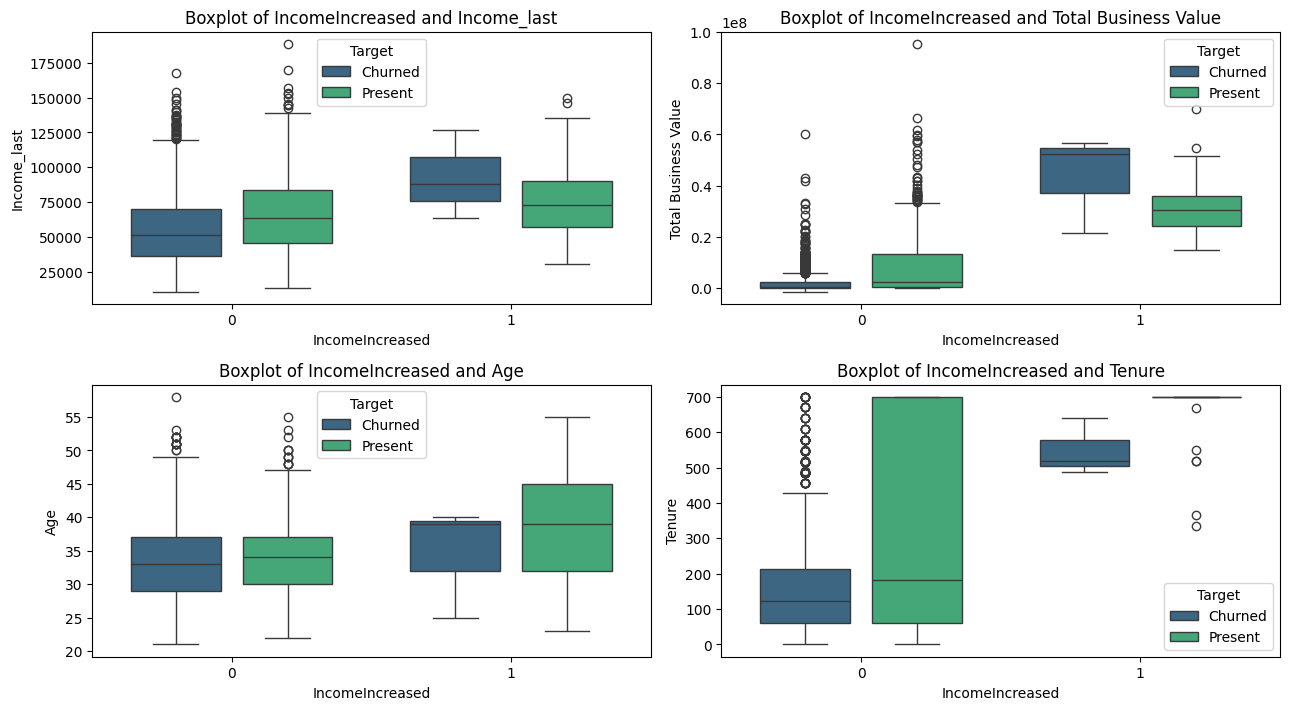

In [251]:
cat = ['Gender', "Education_Level", "Grade", "QuarterlyRatingIncreased", "IncomeIncreased"]
num = ["Income_last", "Total Business Value", "Age", "Tenure"]

for i in range(len(cat)):
  fig = plt.figure(figsize= (13, 35))
  for j in range(len(num)):
      ax= plt.subplot(10, 2, j+1)
      plt.title(f"Boxplot of {cat[i]} and {num[j]}")
      sns.boxplot(x = data[cat[i]], y = data[num[j]], hue = data["Target"], palette= "viridis", gap = 1.8)
      plt.tight_layout()

In [252]:
# Feature 1: Target variable creation:the driver whose last working day is present will have the value 1.
data["Target"] = [0 if i == pd.to_datetime('2099-12-31', format='%Y-%m-%d') else 1 for i in data['LastWorkingDate']]

# Data Preprocessing

In [253]:
df = data.copy()
# Removing Unnecessary columns
df.drop(columns= ["Driver_ID", "MMM-YY_first","MMM-YY_last", "Dateofjoining", "LastWorkingDate"], inplace = True)

Splitting data into training and testing

In [254]:
X = df.drop(columns = "Target")
y = df["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2 ,random_state= 42)

In [255]:
X_train.shape

(1904, 14)

Target encoding the city column

In [256]:
encoder = TargetEncoder(cols = ["City"], return_df = True)
X_train = encoder.fit_transform(X = X_train, y = y_train)
X_test = encoder.transform(X_test)

X_train.shape

(1904, 14)

Class Imbalance treatment using SMOTE: Since Target variable is imbalenced

In [257]:
smote = SMOTE(random_state= 42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
X_train = X_sm
y_train = y_sm

X_train.shape, y_train.shape

((2578, 14), (2578,))

# Model building

**1 Ensemble - Bagging Algorithm**:

model 1: Simple Random Forest Classifier

In [258]:
rf_clf =  RandomForestClassifier(random_state=42, max_depth=5, n_estimators=100)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [259]:
kfold = KFold(n_splits= 10)
results = cross_validate(rf_clf, X_train, y_train, scoring = "accuracy", cv = kfold, return_train_score=True)
print(f"KFold Mean Accuracy for Training: {results['train_score'].mean()*100:.2f} with Standard Deviation of: {results['train_score'].std()*100:.2f}")
print(f"KFold Mean Accuracy for Validation: {results['test_score'].mean()*100:.2f} with Standard Deviation of: {results['test_score'].std()*100:.2f}")

KFold Mean Accuracy for Training: 81.16 with Standard Deviation of: 0.60
KFold Mean Accuracy for Validation: 78.11 with Standard Deviation of: 8.11


Classification Report for simple random forest classifier



In [260]:
y_pred1 = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.76      0.64      0.70       150
           1       0.85      0.91      0.88       327

    accuracy                           0.82       477
   macro avg       0.80      0.77      0.79       477
weighted avg       0.82      0.82      0.82       477



ROC AUC curve

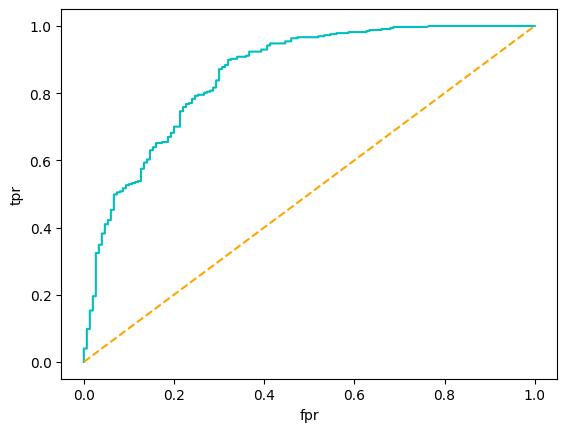

Area under curve for PR AUC 0.8567074413863404


In [261]:
y_prob1 = rf_clf.predict_proba(X_test)
y_probablities1 = y_prob1[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probablities1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='c')
plt.plot([0,1], [0,1], "--", color = "orange")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()
print(f"Area under curve for PR AUC {roc_auc}")


Hyperparameter tunning using GridsearchCV

In [104]:
parameter = {"n_estimators" : [300, 500, 600, 700],
             "max_depth" : [15],
             }

clf = GridSearchCV(RandomForestClassifier(), param_grid = parameter, scoring = "accuracy", cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15],
                         'n_estimators': [300, 500, 600, 700]},
             scoring='accuracy')

In [105]:
print("Best params: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Best params:  {'max_depth': 15, 'n_estimators': 700}
Best score:  0.8433054865658163


In [262]:
model_1 = RandomForestClassifier(random_state = 42, max_depth= 15, max_features = 10, n_estimators = 700)
model_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=10, n_estimators=700,
                       random_state=42)

In [263]:
kfold = KFold(n_splits= 10)
results = cross_validate(model_1, X_train, y_train, scoring = "accuracy", cv = kfold, return_train_score=True)
print(f"KFold Mean Accuracy for Training: {results['train_score'].mean()*100:.2f} with Standard Deviation of: {results['train_score'].std()*100:.2f}")
print(f"KFold Mean Accuracy for Validation: {results['test_score'].mean()*100:.2f} with Standard Deviation of: {results['test_score'].std()*100:.2f}")

KFold Mean Accuracy for Training: 99.99 with Standard Deviation of: 0.02
KFold Mean Accuracy for Validation: 84.80 with Standard Deviation of: 2.02


In [264]:
y_pred = model_1.predict(X_test)

Classification Report for model_1 with hyperparameter tuning

In [265]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       150
           1       0.87      0.87      0.87       327

    accuracy                           0.82       477
   macro avg       0.80      0.80      0.80       477
weighted avg       0.82      0.82      0.82       477



# Result Evaluation: Model 1

The F1 score for predicting class 1 (churned) reached 87%, demonstrating the model's strong ability to correctly identify employees who are likely to churn.
The overall accuracy of our tuned Random Forest Classifier (Model 1) on the testing data is 82%.

ROC AUC curve

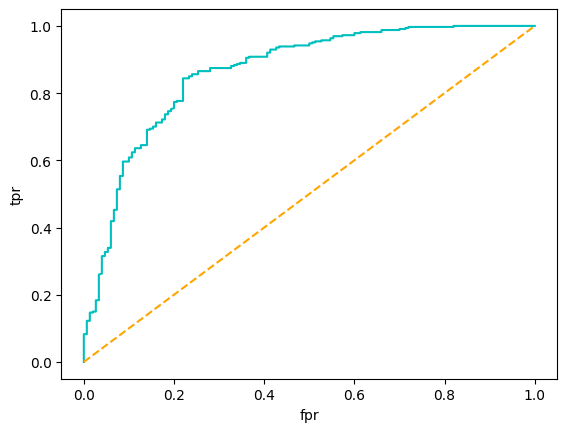

Area under curve for PR AUC 0.8634454638124364


In [147]:
y_prob = model_1.predict_proba(X_test)
y_probablities = y_prob[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probablities)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='c')
plt.plot([0,1], [0,1], "--", color = "orange")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()
print(f"Area under curve for PR AUC {roc_auc}")


Insight:

Model 1, a Random Forest Classifier with hyperparameter tuning, achieved an AUC score of 86%, demonstrating its strong capability to discriminate between the positive class (churned) and the negative class (not churned).

2 Ensemble - Boosting Algorithm:

model 1: Gradient Boosting Classifier

In [266]:
gb_clf = GradientBoostingClassifier(n_estimators=150, max_depth=2, loss = 'log_loss')
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=150)

In [152]:
kfold = KFold(n_splits= 5)
results = cross_validate(gb_clf, X_train, y_train, scoring = "accuracy", cv = kfold, return_train_score=True)
print(f"KFold Mean Accuracy for Training: {results['train_score'].mean()*100:.2f} with Standard Deviation of: {results['train_score'].std()*100:.2f}")
print(f"KFold Mean Accuracy for Validation: {results['test_score'].mean()*100:.2f} with Standard Deviation of: {results['test_score'].std()*100:.2f}")

KFold Mean Accuracy for Training: 87.34 with Standard Deviation of: 0.81
KFold Mean Accuracy for Validation: 81.69 with Standard Deviation of: 3.91


Classification Report for Simple Gradient Boosting Classifier

In [267]:
y_pred1 = gb_clf.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       150
           1       0.86      0.90      0.88       327

    accuracy                           0.83       477
   macro avg       0.81      0.79      0.80       477
weighted avg       0.83      0.83      0.83       477



ROC Curve

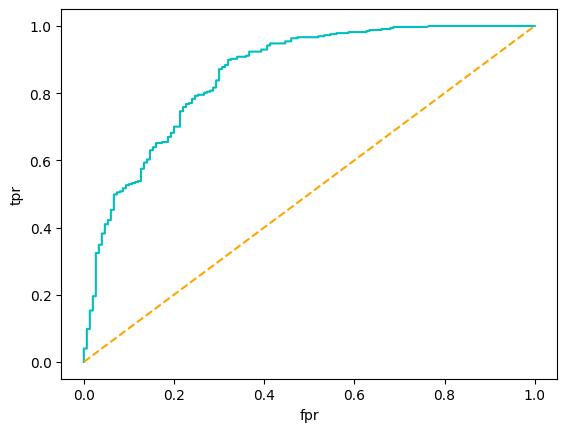

Area under curve for PR AUC 0.8567074413863404


In [268]:
y_prob1 = rf_clf.predict_proba(X_test)
y_probablities1 = y_prob1[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probablities1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='c')
plt.plot([0,1], [0,1], "--", color = "orange")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()
print(f"Area under curve for PR AUC {roc_auc}")


Hyperparameter Tuning for GB classifier

In [160]:
parameter = {"learning_rate" : [0.1, 0.2, 0.5, 1],
             "n_estimators" : [100, 150, 200],
             "subsample" : [1.0, 0.8, 0.5, 0.3],
             "max_depth" : [1, 2, 3, 4],
             "max_features" : [8, 10, 14]}

clf = GridSearchCV(GradientBoostingClassifier(), param_grid = parameter, scoring = "accuracy", cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)

print("Best params: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Best params:  {'learning_rate': 0.2, 'max_depth': 4, 'max_features': 14, 'n_estimators': 200, 'subsample': 0.5}
Best score:  0.8662113343869947


In [276]:
model_2 = GradientBoostingClassifier(learning_rate = 0.2, max_depth = 4, max_features = 14, n_estimators = 200, subsample = 0.5)
model_2.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=4, max_features=14,
                           n_estimators=200, subsample=0.5)

In [270]:
kfold = KFold(n_splits= 5)
results = cross_validate(model_2, X_train, y_train, scoring = "accuracy", cv = kfold, return_train_score=True)
print(f"KFold Mean Accuracy for Training: {results['train_score'].mean()*100:.2f} with Standard Deviation of: {results['train_score'].std()*100:.2f}")
print(f"KFold Mean Accuracy for Validation: {results['test_score'].mean()*100:.2f} with Standard Deviation of: {results['test_score'].std()*100:.2f}")

KFold Mean Accuracy for Training: 99.89 with Standard Deviation of: 0.13
KFold Mean Accuracy for Validation: 83.71 with Standard Deviation of: 0.69


In [277]:
y_pred = model_2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       150
           1       0.85      0.90      0.88       327

    accuracy                           0.82       477
   macro avg       0.80      0.78      0.79       477
weighted avg       0.82      0.82      0.82       477



# **Result Evaluation: Model 2**

Model 2, a Gradient Boosting Classifier with hyperparameter tuning, achieved an F1 score of 88% for class 1 (churned), and an overall accuracy of 83% on the testing data.

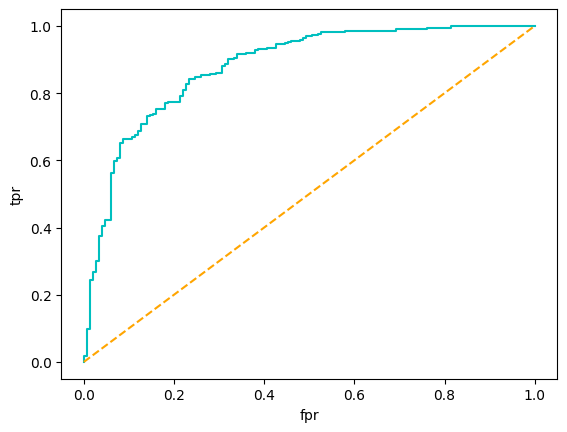

Area under curve for PR AUC 0.8792660550458716


In [169]:
y_prob = model_2.predict_proba(X_test)
y_probablities1 = y_prob[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probablities1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='c')
plt.plot([0,1], [0,1], "--", color = "orange")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()
print(f"Area under curve for PR AUC {roc_auc}")


Insights:

Model 2, a Gradient Boosting Classifier with hyperparameter tuning, achieved an AUC score of 88%, demonstrating its strong ability to distinguish between the positive (churned) and negative (not churned) classes. This performance indicates that Model 2 outperforms Model 1, a Random Forest Classifier, in classification tasks.

Deriving The features which are mostly affecting the churn rate of drivers.

In [192]:
arg = np.argsort(model_2.feature_importances_)
X_train.columns[arg][:4]

Index(['IncomeIncreased', 'QuarterlyRatingIncreased', 'Grade',
       'Education_Level'],
      dtype='object')

Insights:

Based on Model 1, a Gradient Boosting Classifier, the top four most important features affecting driver churn in the dataset are: Income increase, Quarterly Rating increase, Driver's Grade at the time of reporting, and Education Level. The features are ranked in order of their influence as follows: Income increase > Quarterly Rating increase > Grade > Education Level.

In [193]:
arg2 = np.argsort(model_1.feature_importances_)
X_train.columns[arg2][:4]

Index(['IncomeIncreased', 'QuarterlyRatingIncreased', 'Grade',
       'Education_Level'],
      dtype='object')

Similarly, Model 2, also a Gradient Boosting Classifier, has identified the same top four features as most critical in influencing driver churn. These are: Income increase, Quarterly Rating increase, Driver's Grade at the time of reporting, and Education Level. The order of importance remains consistent with Model 1: Income increase > Quarterly Rating increase > Grade > Education Level.

# **Actionable Insights & Recommendations:**

**Insights:**

1. **Key Findings on Churn Drivers:**

* **Gender-Based Churn:**
    39.73% of males have left the job, compared to 28.14% of females, indicating a higher churn rate among males.

* **Education Level and Churn:**
Churn rates are fairly consistent across education levels, with a marginal increase in churn for those with Education Level 2.

* **Designation and Churn:**
Drivers who joined at Designation 1 show the highest churn rate, followed by those at Designation 2.

* **Grade and Churn:**
Half of the drivers within grades 1 and 2 have churned.

* **Quarterly Rating and Churn:**
A last quarterly rating of 1 correlates with a 60% churn rate, highlighting the impact of performance ratings on retention.

* **Overall Churn Rate:**
68% of drivers have churned, indicating a significant imbalance in the workforce stability.

* **Impact of Quarterly Rating Change on Churn:** 64.43% of drivers whose ratings did not increase left the company, versus 3.44% of those who saw rating improvements.

* **Impact of Income Increase on Churn:** 67.74% of drivers without an income increase have churned, marking it as a critical factor in retention.

2. **Model Performance and Insights:**

* **Model 1 (Random Forest Classifier):**

  F1 Score for churn prediction: 87%

  Overall Accuracy: 82%

  AUC Score: 86%

**"This model effectively discriminates between churned and not churned employees, offering robust predictability with fine-tuned parameters."**


* **Model 2 (Gradient Boosting Classifier):**

  F1 Score for churn prediction: 88%

  Overall Accuracy: 83%

  AUC Score: 88%

**Demonstrates superior performance over Model 1 in distinguishing between churned and not churned employees, suggesting a more refined understanding of the feature impacts.**

**3. Most Influential Features:**

* Both Model 1 and Model 2 consistently identified the following features as the most influential in predicting driver churn:

  Income increase

  Quarterly Rating increase

  Driver's Grade at the time of reporting

  Education Level

* The ranking of influence is: Income increase > Quarterly Rating increase > Grade > Education Level.

**Recommendations:**

**1. Gender-Specific Initiatives:**

* Launch targeted retention programs for male employees, focusing on career development, competitive pay, and work-life balance enhancements.

**2. Education Level Focus:**

* Provide additional training and professional development for employees with Education Level 2 to align their roles with their skills and career goals.

**3. Designation-Specific Retention Strategies:**

* Improve job satisfaction for Drivers at Designation 1 and 2 through role enhancements, support mechanisms, and recognition programs.

**4. Grade-Related Adjustments:**

* Enhance support for drivers in grades 1 and 2, including better onboarding, mentorship programs, and reevaluation of compensation structures.

**5. Performance Evaluation:**

* Revamp the performance evaluation process to provide fair, frequent feedback and support structures for low performers.

**6. Development and Recognition Programs:**

* Implement continuous improvement programs that focus on personal development, coaching, and frequent recognition for all performance levels.

**7. Compensation Structure Review:**

* Restructure salary increments and bonus schemes to be competitive and performance-based, ensuring transparency in the paths to income increase.

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [279]:
!jupyter nbconvert --to pdf /content/Business_case_OLA_Ensemble_Learning.ipynb

[NbConvertApp] Converting notebook /content/Business_case_OLA_Ensemble_Learning.ipynb to pdf
[NbConvertApp] Support files will be in Business_case_OLA_Ensemble_Learning_files/
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Learning_files
[NbConvertApp] Making directory ./Business_case_OLA_Ensemble_Lea